# Tasks
<div class="alert alert-block alert-info">
1. Define frequency sample values (Range: $10^2$ - $10^5$, around 100 samples)
    1. I don't recommend having a high density of frequency samples $\omega$. Oversampling frequencies likely yields limiting returns. We just want enough frequencies to reveal characteristics of the solute. 
    2. More important is the actual frequency sampling range.
    2. Another idea is sampling frequencies with a log scale instead of linear.

2. Store experiment data in an impedance matrix.
    1. Data comes in from a series of experiments. One experiment provides frequency-impedance data for a single concentration $c$. 
    1. **Important: Note that for a single concentration $c$, we should run multiple frequency-impedance experiments to mitigate naturally occurring error, and then take some appropriate aggregate (probably the mean).**
    2. Stack the experiment data (one for each concentration) into an impedance matrix Z. Rows index different concentrations, and cols index different frequencies.

3. Analyze function (Input: impedance $z$, range 10e6-10e7) => (Output: concentration $c$, range 0-1) depending on frequency (omega)
    1. Instead of viewing impedance data as a frequency-impedance graph with various concentrations, view the data as an impedance-concentration graph at each frequency $\omega$.
    2. **Very important**: the frequencies $\omega$ are not really variables in the context of a single solute experiment. For all given concentrations, their $\omega$ values are the same, so only the ordered impedance really matters.

4. Parameterize function $f_{\omega}$ for each frequency $\omega$
5. 
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as lab
from scipy.optimize import curve_fit

<a id="logfit"></a>

# Fitting a logarithmic function given input-output

In [2]:
# List of coords (x, y) representing (concentration, impedance)
y = np.array([np.power(10,7), np.power(10,7.5), np.power(10,7.6)])
# X_0 = 0
X_0 = 0.01
X = np.array([X_0, 0.25, 1])

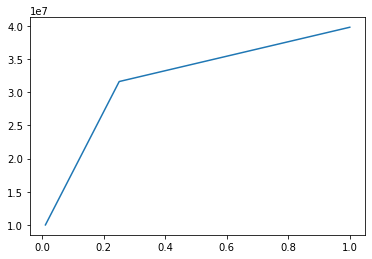

In [3]:
plt.plot(X, y)

In [4]:
fn_list = [np.diag, np.log, np.exp, np.flip, np.mean, np.std]
alt_fn_list = [np.linalg.svd, np.linalg.inv, np.identity]

In [5]:
def assert_precision(check_type, fn_list):
    test = np.array([1, 2, 3], dtype=check_type)
    for fn in fn_list:
        assert fn(test).dtype == check_type

In [6]:
assert_precision(np.float128, fn_list)

In [7]:
def fit_log(X, y, noise=None):
    
    assert X.shape[0] == y.shape[0], "X dim and y dim must match"
    assert (noise is None) or (noise.shape[0] == X.shape[0]), "Must input noise weight for each data point"
    
    n = X.shape[0]
    
    if isinstance(noise, np.ndarray):
        D = np.diag(1 / noise ** 2)
    else:
        D = np.identity(n)
    
#     print(f"D: {D}")
    
    X = np.log(X)
    X = np.vstack((X, np.ones(X.shape[0]))).T
#     w_opt = np.linalg.inv(X.T @ X) @ X.T @ y
    w_opt = np.linalg.solve(X.T @ D @ X, X.T @ D @ y)
    return w_opt

In [8]:
def predict_log(x, w):
    """
    General purpose logarithmic evaluator given weights w = [a, b]
    For our purposes, this function maps (concentration) ==> (impedance)
    
    Input: variable x, weights w = (a, b)
    Output: a * log(x) + b
    """
    a, b = w
    return a * np.log(x, dtype=np.float128) + b
    

In [9]:
def predict_exp(x, w):
    """
    General purpose exponential evaluator given weights w = [a, b]
    This is the inverse of function y = a * log(x) + b
    For our purposes, this function maps (impedance) ==> (concentration)
    
    Input: variable x, weights w = (a, b)
    Output: exp( (y - b) / a )
    """
    a, b = w
    return np.exp( x / a - b / a , dtype=np.float128)

In [10]:
def fit_log2(X, y):
    # Fit the function a * np.log(t - c) + b to x and y
    p0 = ((y[-1] + y[0]) / 2, X[0] - 1, y[0])
    popt, pcov = curve_fit(
        lambda t, a, b, c: a * np.log(t - b) + c, X, y,
        p0=p0, maxfev=100000
    )
    return popt

In [11]:
def predict_log2(x, w):
    a, b, c = w
    return a * np.log(x - b) + c

In [12]:
noise = np.array([1, 1, 1])
w = fit_log(X, y, noise)

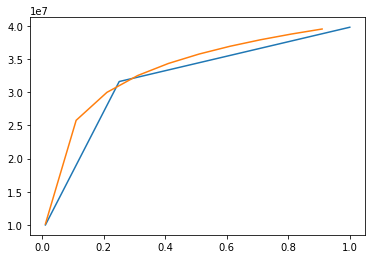

In [13]:
domain = np.arange(0.01, 1, 0.1)
output = np.array([predict_log(x, w) for x in domain])
plt.plot(X, y)
plt.plot(domain, output)

# Yeast Impedance Data (.csv)

<div class="alert alert-block alert-info">
The provided yeast impedance data represents frequency-impedance data for the concentrations 0, 0.25, and 1. <br>
This dataset is very limited in terms of data analysis, and ideally we would have many more concentration readings. Still, it provides a good model for how actual data will look.<br>
For each frequency $\omega$, we will fit a concentration-impedance curve based on a logarithmic function. This will serve as a model to fill in missing data. This will allow use to generate impedance values for any concentration.<br>
These functions, defined by a set of weights, uniquely map concentration to impedance for any given frequency.<br>
If this is confusing, just use the wrapper function <a href='#c_to_z'>c_to_z</a>. Note that it takes in the index of the desired frequency, not the frequency value itself.
</div>

In [14]:
import pandas as pd

In [15]:
filename = r"Yeast measurement 20220211 (Clean).csv"
df = pd.read_csv(filename)

In [16]:
df.tail(5)

,freq / Hz,Z (Yeast - weird),Z (Yeast1),Z (Yeast2),Z (Yeast3),Z (Yeast4),Z (1:4 Yeast1),Z (1:4 Yeast2),Z (1:4 Yeast3),Z (Base1),Z (Base2),Z (Base3),Z (unknown)
22,260.151,9510000.0,21100000.0,33100000.0,60300000.0,14700000.0,22400000.0,23400000.0,17600000.0,13700000.0,13500000.0,8720000.0,4150000.0
23,204.842,9910000.0,20700000.0,36300000.0,63900000.0,15100000.0,23800000.0,25900000.0,19500000.0,13700000.0,13900000.0,8950000.0,4190000.0
24,161.291,9630000.0,20600000.0,35600000.0,71900000.0,15000000.0,23600000.0,24200000.0,18400000.0,13900000.0,13800000.0,8560000.0,4190000.0
25,127.000,9830000.0,19400000.0,36100000.0,81100000.0,15100000.0,23900000.0,24800000.0,18600000.0,14000000.0,14000000.0,8180000.0,4750000.0
26,100.000,9270000.0,19800000.0,39100000.0,71100000.0,15400000.0,25100000.0,23700000.0,16400000.0,13800000.0,13600000.0,8650000.0,4260000.0


In [17]:
freqs = np.flip(df.iloc[:,0].to_numpy())
concentrations = np.array([0.01, 0.25, 1])
# yeast = np.flip(df.iloc[:,[1,2,3,4,5]].to_numpy(), axis=0)
yeast_samp = np.flip(df.iloc[:,[2,3,4,5]].to_numpy(), axis=0)
yeast1_4_samp = np.flip(df.iloc[:,[6,7,8]].to_numpy(), axis=0)
base_samp = np.flip(df.iloc[:,[9,10,11]].to_numpy(), axis=0)

In [18]:
for data in [freqs, yeast_samp, yeast1_4_samp, base_samp]:
    print(data.shape)

(27,)
(27, 4)
(27, 3)
(27, 3)


In [19]:
yeast = np.mean(yeast_samp, axis=1)
yeast1_4 = np.mean(yeast1_4_samp, axis=1)
base = np.mean(base_samp, axis=1)

Text(0, 0.5, 'Impedance (Ohms)')

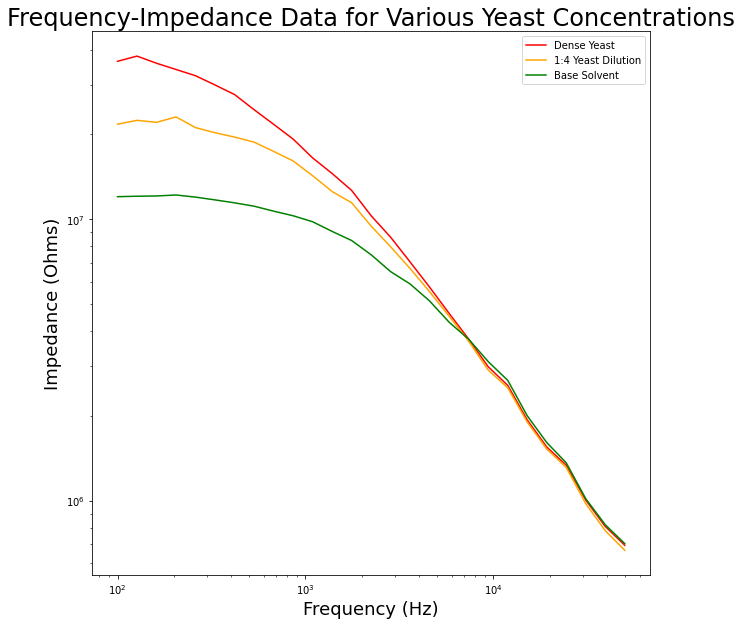

In [153]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")
ax.set_xscale("log")

plt.plot(freqs, yeast, color="red", label="Dense Yeast")
plt.plot(freqs, yeast1_4, color="orange", label="1:4 Yeast Dilution")
plt.plot(freqs, base, color="green", label="Base Solvent")
plt.legend()
plt.title("Frequency-Impedance Data for Various Yeast Concentrations", size=24)
plt.xlabel("Frequency (Hz)", size=18)
plt.ylabel("Impedance (Ohms)", size=18)

Text(0.5, 1.0, 'Right Split Zoomed')

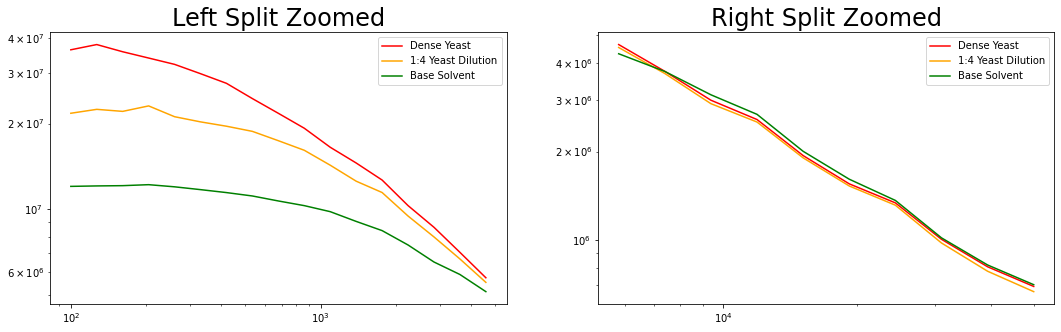

In [21]:
split_idx = 17

fig, ax = plt.subplots(1, 2, figsize=(18,5))

ax[0].set_yscale("log")
ax[0].set_xscale("log")

ax[0].plot(freqs[:split_idx], yeast[:split_idx], color="red", label="Dense Yeast")
ax[0].plot(freqs[:split_idx], yeast1_4[:split_idx], color="orange", label="1:4 Yeast Dilution")
ax[0].plot(freqs[:split_idx], base[:split_idx], color="green", label="Base Solvent")
ax[0].legend()
ax[0].set_title("Left Split Zoomed", size=24)

ax[1].set_yscale("log")
ax[1].set_xscale("log")

ax[1].plot(freqs[split_idx:], yeast[split_idx:], color="red", label="Dense Yeast")
ax[1].plot(freqs[split_idx:], yeast1_4[split_idx:], color="orange", label="1:4 Yeast Dilution")
ax[1].plot(freqs[split_idx:], base[split_idx:], color="green", label="Base Solvent")
ax[1].legend()
ax[1].set_title("Right Split Zoomed", size=24)

In [22]:
# Frequency-impedance for various concentrations ==> impedance-concentration for various frequencies
print(yeast.shape)
print(yeast1_4.shape)
print(base.shape)

(27,)
(27,)
(27,)


In [23]:
# Stack data by columns to create a matrix Z with impedance data
# Rows are indexed by concentration
# Cols are indexed by frequency
Z = np.vstack((base, yeast1_4, yeast))

In [24]:
Z.shape

(3, 27)

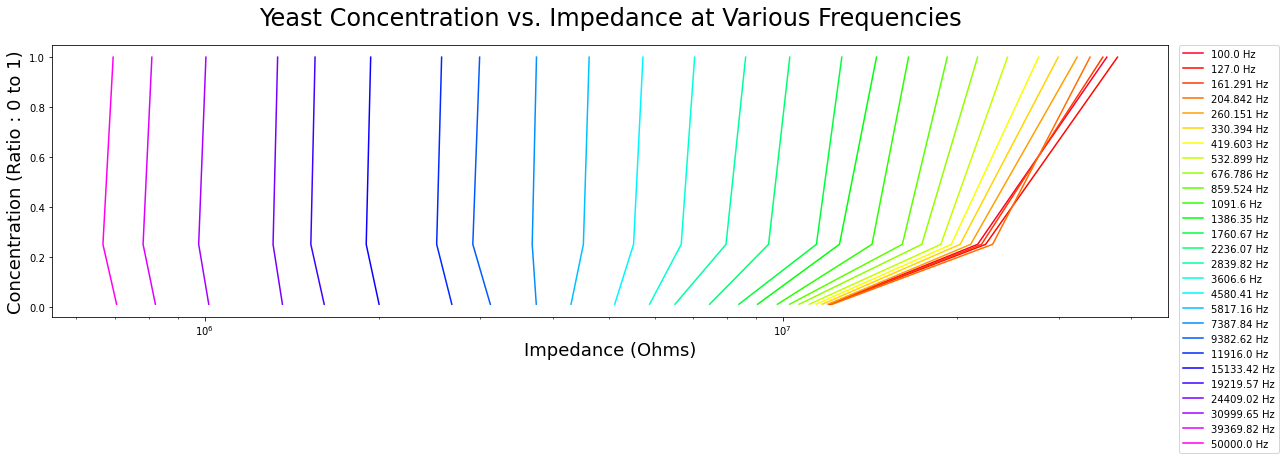

In [25]:
cm = plt.get_cmap('gist_rainbow')
fig, ax = plt.subplots(1, figsize=(20,5))

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("Impedance (Ohms)", size=18)
ax.set_ylabel("Concentration (Ratio : 0 to 1)", size=18)
ax.set_title("Yeast Concentration vs. Impedance at Various Frequencies", size=24, y=1.05)
ax.set_prop_cycle(color=[cm(1.*i/len(freqs)) for i in range(len(freqs))])

for i in range(len(freqs)): 
#     ax[0].plot(concentrations, Z[:,i], label=str(freqs[i])+" Hz")
    ax.plot(Z[:,i], concentrations, label=str(freqs[i])+" Hz")
ax.legend(bbox_to_anchor=(1.01, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()


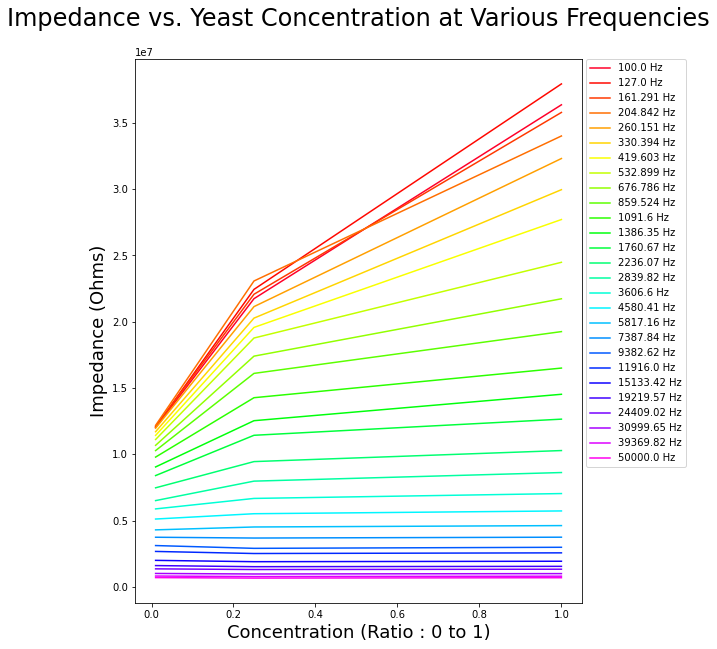

In [26]:
fig, ax = plt.subplots(1, figsize=(8,10))

# ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("Concentration (Ratio : 0 to 1)", size=18)
ax.set_ylabel("Impedance (Ohms)", size=18)
ax.set_title("Impedance vs. Yeast Concentration at Various Frequencies", size=24, y=1.05)
ax.set_prop_cycle(color=[cm(1.*i/len(freqs)) for i in range(len(freqs))])

for i in range(len(freqs)): 
#     ax[0].plot(concentrations, Z[:,i], label=str(freqs[i])+" Hz")
    ax.plot(concentrations, Z[:,i], label=str(freqs[i])+" Hz")
ax.legend(bbox_to_anchor=(1.01, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

In [27]:
yeast_samp.shape

# rows index freqs, cols index samples

(27, 4)

In [28]:
# Computing std dev across various frequencies

yeast_noise = np.std(yeast_samp, axis=1)
yeast1_4_noise = np.std(yeast1_4_samp, axis=1)
base_noise = np.std(base_samp, axis=1)

Text(0.5, 1.05, 'Frequency-Noise Data for Various Yeast Concentrations')

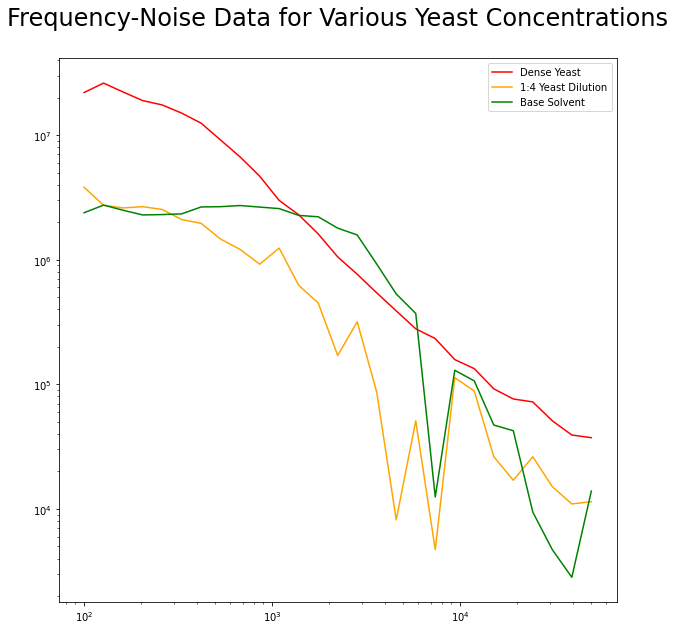

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")
ax.set_xscale("log")

plt.plot(freqs, yeast_noise, color="red", label="Dense Yeast")
plt.plot(freqs, yeast1_4_noise, color="orange", label="1:4 Yeast Dilution")
plt.plot(freqs, base_noise, color="green", label="Base Solvent")
plt.legend()
plt.title("Frequency-Noise Data for Various Yeast Concentrations", size=24, y=1.05)

In [30]:
noise = np.vstack((base_noise, yeast1_4_noise, yeast_noise))

In [31]:
noise.shape

# Rows index concentration
# Cols index frequency

(3, 27)

# Fitting log functions to the experimental data
<div class="alert alert-block alert-info">
Notice the function above that maps (concentration) ==> (impedance) approximates a log function at each frequency. Of course, we only have 3 concentration samples (0.01, 0.25, and 1), but this is my educated guess. For more details, see the section <a href="#logfit">"Fitting a logarithmic function given input-output data"</a>.
</div>

<div class="alert alert-block alert-info">
Don't worry if the plotting code is confusing or if you don't understand the logarithmic fitting.<br>
The summary is that you should use the provided "c_to_z" function to generate data.<br>
You can use the function "freq_sweep_at_c" to simulate an experiment collecting impedance data at any concentration.
</div>

In [32]:
# Store learned weights from fitting log functions
# Maps concentration ==> impedance
NUM_PARAMS = 2

weights = np.empty((freqs.shape[0], NUM_PARAMS))
for i in range(len(freqs)): 
    w_i = fit_log(concentrations, Z[:,i], noise[:,i])
    weights[i] = w_i
print(weights)

[[ 3.16563942e+06  2.65452658e+07]
 [ 3.29093050e+06  2.71642120e+07]
 [ 3.17189123e+06  2.66440199e+07]
 [ 3.44548975e+06  2.80127386e+07]
 [ 2.92623461e+06  2.53974895e+07]
 [ 2.72880698e+06  2.42103549e+07]
 [ 2.60318435e+06  2.33296180e+07]
 [ 2.42826018e+06  2.22161762e+07]
 [ 2.13665781e+06  2.04231028e+07]
 [ 1.84189068e+06  1.86846073e+07]
 [ 1.42669481e+06  1.62948663e+07]
 [ 1.14332244e+06  1.41571710e+07]
 [ 9.26062345e+05  1.27103891e+07]
 [ 6.09373005e+05  1.02943274e+07]
 [ 4.60682930e+05  8.61722763e+06]
 [ 2.52061351e+05  7.02337029e+06]
 [ 1.31276237e+05  5.70200521e+06]
 [ 6.94118998e+04  4.61662535e+06]
 [-1.85896239e+04  3.66094821e+06]
 [-4.03111387e+04  2.91163488e+06]
 [-3.23652077e+04  2.51162597e+06]
 [-2.65373426e+04  1.87394157e+06]
 [-2.25095648e+04  1.49924453e+06]
 [-1.33458948e+04  1.30160994e+06]
 [-1.08718928e+04  9.66456826e+05]
 [-1.08515239e+04  7.71940407e+05]
 [-9.42758427e+03  6.58762909e+05]]


In [33]:
weights = weights.astype(np.float128)

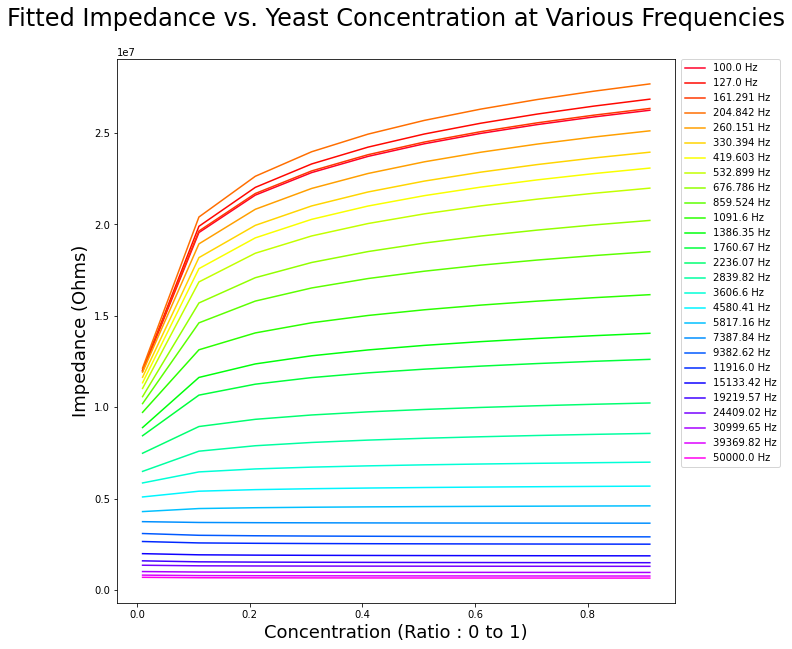

In [34]:
fig, ax = plt.subplots(1, figsize=(10,10))

# ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("Concentration (Ratio : 0 to 1)", size=18)
ax.set_ylabel("Impedance (Ohms)", size=18)
ax.set_title("Fitted Impedance vs. Yeast Concentration at Various Frequencies", size=24, y=1.05)
ax.set_prop_cycle(color=[cm(1.*i/len(freqs)) for i in range(len(freqs))])

for i in range(len(freqs)): 
    output = [predict_log(x,weights[i]) for x in domain]
    ax.plot(domain, output, label=str(freqs[i])+" Hz")
ax.legend(bbox_to_anchor=(1.01, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

# Generate exact data based on model at various concentrations

**Generate impedance data based on concentration and frequency, store in Z_true.**

In [35]:
# Generated concentrations in range (0.01, 1)
concs = [c / 100 for c in range(1, 100, 10)] + [1]
concs

[0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1]

***If there's an error above, you can safely ignore it. Read the comments for more details.***

In [224]:
def plot_rows(M, x, y, alpha=1):
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    m = M.shape[0]
    ax.set_prop_cycle(color=[cm(1.*i/m) for i in range(m)])

    for i in range(m):
        plt.plot(x, M[i], label="c = " + str(y[i]), alpha=alpha)

    ax.legend(bbox_to_anchor=(1.01, 1),
                             loc='upper left', borderaxespad=0., ncol=1)
    ax.set_title("Frequency-Impedance Data for Various Yeast Concentrations", size=24)
    ax.set_xlabel("Frequency (Hz)", size=18)
    ax.set_ylabel("Impedance (Ohms)", size=18)

<a id='c_to_z'></a>

In [199]:
def c_to_z(c, freq_idx, weights=weights):
    """
    Wrapper utility function mapping (concentration) ==> (impedance) at a given frequency.
    Simply calls the fitted logarithmic function.
    """
    return predict_log(c, weights[freq_idx])

In [200]:
def freq_sweep_at_c(c, weights=weights):
    """
    Mimics a biosensing experiment at a single concentration c > 0. Note that the sweep doesn't impart any error.
    Any impedance values are exactly generated from the model.
    
    Input: Concentration C
           Set of weights describing the function (concentration) ==> (impedance) at each frequency.
           
    Output: A list of impedance values, one for each frequency.
    """
    assert c > 0
    return np.array([c_to_z(c, i, weights) for i in range(len(freqs))])

In [201]:
def generate_experiment(concs, weights=weights):
    """
    Generates an (m x n) data matrix with impedance values.
    Each row represents a single concentration.
    Each col represents a single frequency.
    """
    m = len(concs)
    n = freqs.shape[0]
    Z = np.empty((m, n))
    for i, c in enumerate(concs):
        Z[i] = freq_sweep_at_c(c, weights)
    return Z

Text(0, 0.5, 'Impedance (Ohms)')

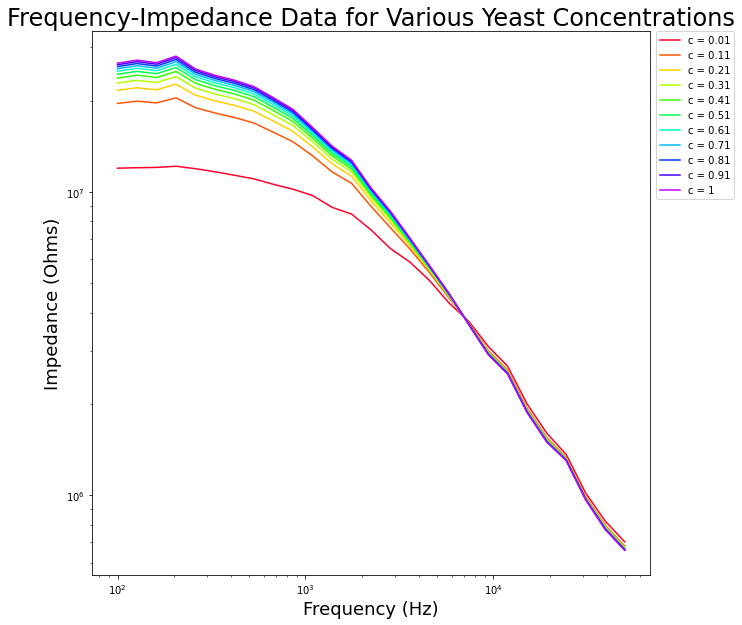

In [202]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_prop_cycle(color=[cm(1.*i/len(concs)) for i in range(len(concs))])

for c in concs:
    plt.plot(freqs, freq_sweep_at_c(c), label="c = " + str(c))

ax.legend(bbox_to_anchor=(1.01, 1),
                         loc='upper left', borderaxespad=0., ncol=1)
ax.set_title("Frequency-Impedance Data for Various Yeast Concentrations", size=24)
ax.set_xlabel("Frequency (Hz)", size=18)
ax.set_ylabel("Impedance (Ohms)", size=18)

In [203]:
print(f"Frequencies (Hz): \n{freqs}\n")
print(f"Generated concentrations (Ratio, range (0, 1]): \n{concs}")

Frequencies (Hz): 
[  100.      127.      161.291   204.842   260.151   330.394   419.603
   532.899   676.786   859.524  1091.6    1386.35   1760.67   2236.07
  2839.82   3606.6    4580.41   5817.16   7387.84   9382.62  11916.
 15133.42  19219.57  24409.02  30999.65  39369.82  50000.   ]

Generated concentrations (Ratio, range (0, 1]): 
[0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1]


# Sample Data and Noise Simulation

In [204]:
import sklearn
import ipywidgets as ipyw

np.random.seed(42)

In [205]:
# Generated 11 concentration values in range (0.01, 1)
concs = [c / 100 for c in range(1, 100, 10)] + [1]

m = len(concs)
n = len(freqs)
print((m, n))

(11, 27)


In [206]:
# User-created noise values. In general, low frequency ==> high noise. Here, we'll just average the noise from
# the yeast dataset.

# Let's assume the noise at a single frequency is constant for simplicity

noise_at_freq = np.mean(noise, axis=0)
noise_at_freq.shape

(27,)

In [207]:
def generate_noise(m, n, noise_at_freq):
    """
    Return matrix of noise at each concentration (rows) and frequency (cols).
    """
    noises = np.empty((m, n))
    zeros = np.zeros(n)
    for i in range(m):
        noises[i] = np.random.normal(zeros, noise_at_freq)
        
    return noises

In [208]:
def avg_noise(n_samples, noise_at_freq):
    """
    Repeatedly generate noise for n_samples and return the average.
    By the central limit theorem, as n_samples increases, average_noise should return to zero.
    
    n_samples is limited to 1000 to avoid overflow issues, as the noise scale is quite large at around 10^6
    """
    assert n_samples <= 1000
    
    agg = np.zeros((m, n))
    for i in range(n_samples):
        agg += generate_noise(m, n, noise_at_freq) / n_samples
    
    return agg

In [209]:
def plot_sample_data(n_samples=100, noise_scale=0.1):
    
    noises = avg_noise(n_samples, noise_at_freq)
    X_noisy = X_true + noise_scale * noises
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_prop_cycle(color=[cm(1.*i/m) for i in range(m)])

    for i in range(m):
        plt.plot(freqs, X_noisy[i], label="c = " + str(concs[i]))

    ax.legend(bbox_to_anchor=(1.01, 1),
                             loc='upper left', borderaxespad=0., ncol=1)
    ax.set_title(f"Noisy Frequency-Impedance Data, n_samples={n_samples}", size=24)
    ax.set_xlabel("Frequency (Hz)", size=18)
    ax.set_ylabel("Impedance (Ohms)", size=18)

In [210]:
display(
    ipyw.interact_manual(plot_sample_data, 
                  n_samples=ipyw.BoundedIntText(
                    value=3,
                    min=1,
                    max=1000,
                    step=1,
                    description='N_Samples:',
                    disabled=False,
                    continuous_update=True
                  ), noise_scale=(0,1,0.1)
        )
)    

interactive(children=(BoundedIntText(value=3, continuous_update=True, description='N_Samples:', max=1000, min=…

<function __main__.plot_sample_data(n_samples=100, noise_scale=0.1)>

# Now, ML can begin!

<div class="alert alert-block alert-info">
All the setup has been done! At this point we have:
<ol>
    <li>Cleaned the dataset</li>
    <li>Conveniently formatted the data</li>
    <li>Visually plotted and analyzed the relationships between frequency, impedance, and concentration</li>
    <li>Fit a logarithmic data model to the dataset, allowing us to simulate exact experimental data</li>
    <li>Created a noise generator fitted to the original dataset, allowing us to simulate the original noisy data</li>
</ol>

In other words, for any given concentration, we can generate an exact impedance output using our model. Let's use our model as the ground truth.<br>

This allows us to generate impedance data at a known concentration, add some realistic noise, and test how well various ML algorithms can recover the original concentration value. This is a core ML task -- regression.
</div>

In [211]:
from scipy.stats import hmean
from scipy.stats.mstats import gmean

In [212]:
def fit(X, y, model='nitro', concs=None):
    """
    Fits a linear model to the data. If X is wide, attempts to fit via an RV decomposition.
    """
    m, n = X.shape
    if model == 'linear':
        if m < n:
            U, d, Vh = np.linalg.svd(X)
            R = U @ np.diag(d)
            V = Vh.T
            w_opt = V[:,:m] @ np.linalg.inv(R.T @ R) @ R @ y

        else:
            w_opt = np.linalg.inv(X.T @ X) @ X.T @ y
        
    elif model == 'nitro':
        assert concs is not None and len(concs) == m, "Must input valid concentrations"
        
        w = np.empty((n, 2))
        for i in range(n):
            w[i] = fit_log(np.array(concs), X[:,i])
            
        return w
        
    
    
    return w_opt

In [213]:
def predict(X, w, model='nitro', agg=gmean, exclude_fns=0, return_preds=False):
    """
    Predict concentration given a list of impedances.
    """
    if model == 'linear':
        return X @ w
    
    elif model == 'nitro':
        
        assert agg is not None, "Must input valid aggregation function"
#         assert len(weights) == len(X), "Must input weights for each frequency"
        
        n = len(X) # Number of elements in input vector
        
        preds = np.empty(n - exclude_fns)
        for j in range(w.shape[0] - exclude_fns):
#             print(f"Freq {j}: {predict_exp(X[j], w[j])}")
            preds[j] = predict_exp(X[j], w[j])
    
        if return_preds:
            return agg(preds), preds
        else: 
            return agg(preds)
            

In [214]:
print(f"Frequencies (Hz): \n{freqs}\n")
print(f"Generated concentrations (Ratio, range (0, 1]): \n{concs}")

Frequencies (Hz): 
[  100.      127.      161.291   204.842   260.151   330.394   419.603
   532.899   676.786   859.524  1091.6    1386.35   1760.67   2236.07
  2839.82   3606.6    4580.41   5817.16   7387.84   9382.62  11916.
 15133.42  19219.57  24409.02  30999.65  39369.82  50000.   ]

Generated concentrations (Ratio, range (0, 1]): 
[0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1]


In [220]:
# Generate noise matrix

train_noise_scale = 0.4
n_samples = 9

noises = avg_noise(n_samples, noise_at_freq)

# Generate true data at known concentrations CONCS and frequencies FREQS

X_true = generate_experiment(concs)
y_true = np.array(concs)
print(X_true.shape)
print(y_true.shape)

# Adding averaged noise to our data matrix X.
# In practice, we won't have X_TRUE, we will only get the noisy matrix X.

X = X_true + train_noise_scale * noises

(11, 27)
(11,)


In [221]:
# Fit the model to noisy X matrix
fit_w = fit(X, y, concs=concs)

###############
true_conc = 0.42
###############

# Generate noisy test data
test_noise_scale = 0.01
noises = test_noise_scale * np.random.normal(0, noise_at_freq)

X_test = freq_sweep_at_c(true_conc) + noises

# Predict noisy test concentration
agg_pred, preds = predict(X_test, fit_w, agg=gmean, exclude_fns=0, return_preds=True)

In [222]:
print(f"Train noise scale: {train_noise_scale}")
print(f"Number of training samples: {n_samples}")
print(f"Test noise scale: {test_noise_scale}")
print("***********\n")
print(f"True concentration: {true_conc}")

Train noise scale: 0.4
Number of training samples: 9
Test noise scale: 0.01
***********

True concentration: 0.42


<div class="alert alert-block alert-info">
Notice that in the graph below, the model prediction can have quite a large error at any given frequency. However, taking the aggregation greatly reduces the overall error by a fascinating amount.
</div>

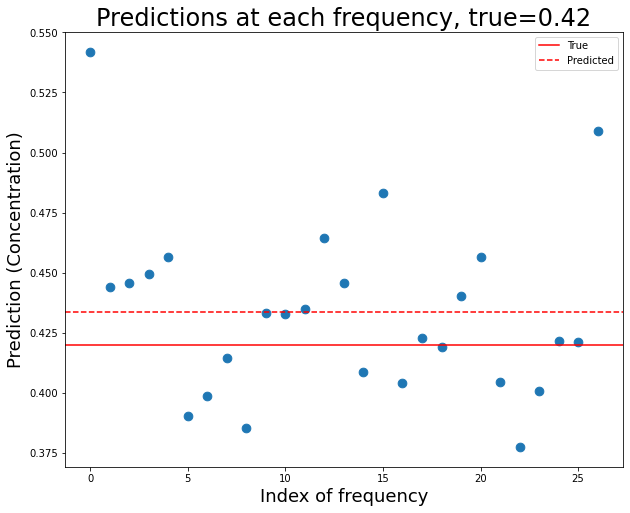

In [223]:
plt.figure(figsize=(10,8))

plt.scatter([i for i in range(len(preds))], preds, s=75)
plt.axhline(y=true_conc, color='r', linestyle='-', label="True")
plt.axhline(y=np.mean(preds), color='r', linestyle='--', label="Predicted")

plt.title(f"Predictions at each frequency, true={true_conc}", size=24)
plt.xlabel("Index of frequency", size=18)
plt.ylabel("Prediction (Concentration)", size=18)
plt.legend()

<div class="alert alert-block alert-info">
Notice the extreme noise in the graph below, making the concentration curves indistinguishable. The dotted black
line is the test data that we must predict. If the true concentration was not known, it would be impossible to 
intuitively determine the true value that created this curve.<br> 
<br>Also note that due to noise, it is impossible to get
a perfectly accurate prediction. Still, the model performs extremely well even under high noise.
</div>

Text(0.5, 1.0, 'Frequency-Impedance Data, True Concentration=0.42')

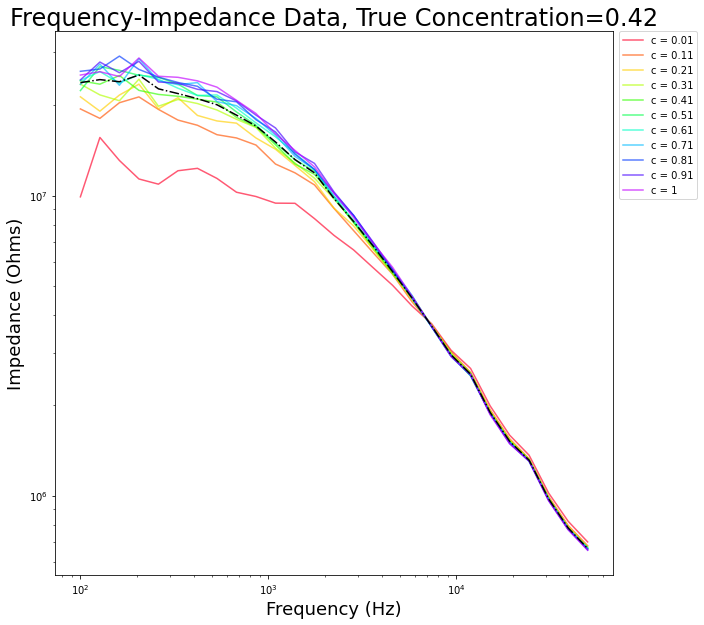

In [225]:
plot_rows(X, freqs, concs, alpha=0.65)
plt.plot(freqs, X_test, linestyle="-.", color="k")
plt.title(f"Frequency-Impedance Data, True Concentration={true_conc}", size=24)

# Model Analysis

<div class="alert alert-block alert-info">
We have a trained model that is surprisingly accurate even given nonsensical data! Now, for a given trained model, let's test its accuracy on a given known concentration. We should expect a bell curve shape, with a mean close to the true concentration value.
</div>

In [108]:
def collect_preds_at_c(c, model_w, noise_scale=0.1, noise_at_freq=noise_at_freq, n_samp=9, agg=gmean,
                      exclude_fns=0):
    """
    For a fitted model, generate predictions for a single sample with true concentration C.
    Collects N_SAMP test samples, returning N_SAMP predictions.
    """
    preds = np.zeros(n_samp)
    
    for i in range(len(preds)):
        noises = noise_scale * np.random.normal(0, noise_at_freq)
        X_test = freq_sweep_at_c(c) + noises
        
        preds[i] = predict(X_test, model_w, agg=agg, exclude_fns=exclude_fns, return_preds=False)
    
    return preds

In [109]:
def test_model(c, noise_scale=0.1, n_runs=9, n_train_samp=9, concs=concs, noise_at_freq=noise_at_freq, 
               test_noise_scale=0.1, agg=gmean, exclude_fns=0):
    """
    Generate N_RUNS models using noisy data.
    """
    
    preds = np.zeros(n_runs)
    
    # Generate true data at known concentrations CONCS and frequencies FREQS
    X_true = generate_experiment(concs)
    y_true = np.array(concs)
        
    for i in range(n_runs):
        noises = avg_noise(n_train_samp, noise_at_freq)

        # Adding averaged noise to our train data matrix X.
        X = X_true + noise_scale * noises
        
        fit_w = fit(X, y, concs=concs)
        preds[i] = np.mean(collect_preds_at_c(c, fit_w, noise_scale=test_noise_scale, agg=agg))
    
    return preds

<div class="alert alert-block alert-info">
Remember that this algorithm works by making a prediction at each frequency, then aggregating each prediction
into a more accurate one. The graph below analyzes the performance of each aggregator. <br><br>Basically, we test the model on various concentration values and measure the signed error. Notice that the standard arithmetic mean degrades in performance at high concentrations.<br><br>
    Therefore, we use the geometric mean (gmean) because the frequency data was collected on a log scale.
</div>

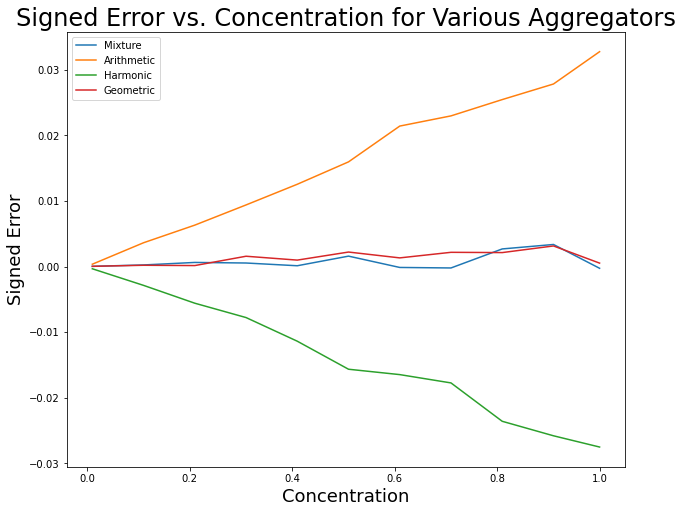

In [156]:
custom = lambda lst: (np.mean(lst) + hmean(lst) + gmean(lst)) / 3
plt.figure(figsize=(10, 8))
for agg_fn, name in zip((custom, np.mean, hmean, gmean), ("Mixture", "Arithmetic", "Harmonic", "Geometric")):
    errs = [np.mean(test_model(c, n_runs=81, n_train_samp=9, agg=agg_fn)) - c for c in concs]
    plt.plot(concs, errs, label=name)
    
plt.title("Signed Error vs. Concentration for Various Aggregators", size=24)
plt.xlabel("Concentration", size=18)
plt.ylabel("Signed Error", size=18)
plt.legend()

In [161]:
true_conc = 0.01
test_preds = test_model(true_conc, noise_scale=0.4, n_runs=9, n_train_samp=9, test_noise_scale=0.01, agg=gmean)
test_preds

array([0.01058166, 0.00897842, 0.00996554, 0.00993248, 0.01067352,
       0.01011463, 0.0098742 , 0.01037385, 0.00936333])

In [162]:
mu = np.mean(test_preds)
z = np.std(test_preds)

<div class="alert alert-block alert-info">
Here we test the model's performance by training and testing the model multiple times, generating multiple predictions.<br><br>We can calculate the mean and standard deviation of the predictions to understand the model's accuracy. Remember that 95% of values fall within +/- 2 standard deviations.<br><br>This way, we generate a 95% confidence interval for the model's predictions. The tighter the interval, the more accurate our predictions.<br><br>The full confidence interval has a width less than 0.025. Our operating concentration range was 0 through 1, so the error on either side is only around 1.25%, which is fantastic for such noisy data.<br><br>This means that if our operating concentration range is in the micro-range, our precision would almost be in the nano-range.
</div>

In [163]:
def plot_confidence(mu, z, true_conc, test_preds=test_preds, x_window='auto'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.errorbar(mu, 0, xerr=2*z, marker='o', mfc='k', ms=3, lw=1, capsize=5, capthick=1, ecolor='k')
    ax.scatter(test_preds, np.full(len(test_preds), 0.1))
    ax.axvline(true_conc, ls='--', c='r')
    plt.text(0.05,
         0.8,
         f"z={z: .9f}",
             size=14,
         transform=plt.gca().transAxes)

    ax.set_title(f"95% Confidence Interval, True Concentration = {true_conc}", size=24, y=1.05)
    if x_window == 'auto':
        ax.set_xlim(mu - 2*z - 0.01, mu + 2*z + 0.01)
    else:
        ax.set_xlim(0.01, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-0.1, 0.2)

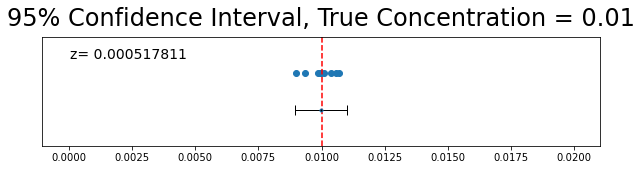

In [164]:
plot_confidence(mu, z, true_conc)

In [195]:
def plot_z(concs):
    """
    Plot standard deviation of model predictions at various concentrations CONCS.
    """
    z_vals = np.zeros(len(concs))
    for i, c in enumerate(concs):
        preds = test_model(c, noise_scale=0.4, n_runs=40, n_train_samp=9, test_noise_scale=0.01, 
                                agg=gmean)
        z_vals[i] = np.std(preds)
        
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.scatter(concs, z_vals, s=100)
    ax.set_title(f"Error Std. Dev. vs. Concentration", size=24)
    ax.set_xlabel("Concentration", size=18)
    ax.set_ylabel("Standard Deviation", size=18)
    

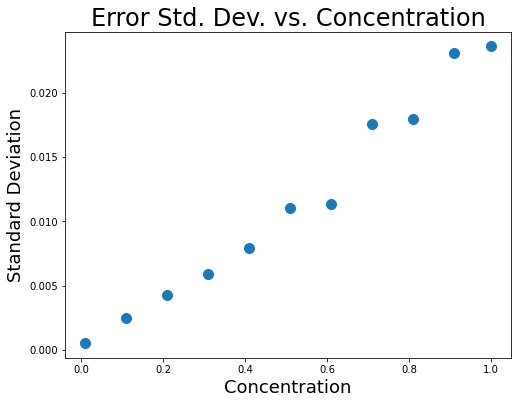

In [196]:
plot_z(concs)